In [1]:
import pandas as pd
import pylab as plt

In [2]:
import param
import datetime as dt
import panel as pn

## Panel short demo

In [16]:
def interact_example(a=2, b=3):
    
    plot = plt.figure()
    ax = plot.add_subplot(111)
    
    pd.Series({'a':a, 'b':b}).plot(kind='bar',ax=ax)


    plt.tight_layout()
    plt.close(plot)
    return plot

Column
    [0] Column
        [0] IntSlider(end=6, name='a', start=-2, value=2)
        [1] IntSlider(end=9, name='b', start=-3, value=3)
    [1] Row
        [0] Matplotlib(Figure, name='interactive00094')
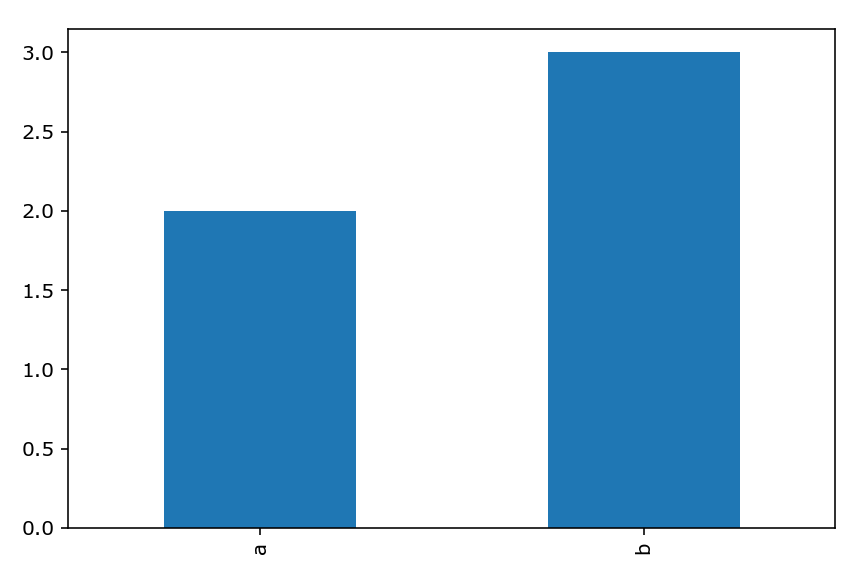

In [17]:
pn.interact(interact_example)

# Dashboard

In [3]:
path = 'https://raw.githubusercontent.com/PacktPublishing/Python-Programming-Projects-Learn-Python-3.7-by-building-applications/master/Chapter16/data/top5.csv'

In [4]:
DATA = pd.read_csv(path, parse_dates=['date'])

In [5]:
DATA.head(3)

,date,boro,metric,value
0,2019-01-01,Unspecified,DCA / DOH New License Application Request,70
1,2019-01-01,NYC,Noise - Residential,5068
2,2019-01-01,NYC,HEAT/HOT WATER,5068


In [6]:
DATA['boro'] = DATA.boro.str.lower()

In [7]:
DATA.boro.unique()

array(['unspecified', 'nyc', 'bronx', 'brooklyn', 'manhattan', 'queens',
       'staten island'], dtype=object)

In [8]:
bounds = (dt.datetime(2019,1,1),dt.datetime(2019,5,30))


class Timeline(param.Parameterized):
    dr = param.DateRange(bounds=bounds, default=bounds)

    
    boros = param.ListSelector(default=['Manhattan', 'Bronx', 'Brooklyn', 'Queens', 'Staten Island'], objects=['Manhattan', 'Bronx', 'Brooklyn', 'Queens', 'Staten Island', 'Unspecified'])
                            
    @param.depends('dr', 'boros')
    def view_tl(self):
        start, end = pd.to_datetime(self.dr[0]), pd.to_datetime(self.dr[1])
        boro_mask = DATA.boro.isin([el.lower() for el in self.boros])
        
        time_data = DATA[(DATA.metric == 'complaints')&boro_mask].set_index(['date', 'boro']).unstack()
        data = time_data[(time_data.index >= start) & (time_data.index <= end)]
        data.columns = data.columns.get_level_values(-1)
        plot = plt.figure(figsize=(10,5))
    
        ax = plot.add_subplot(111)
        
        data.plot(ax=ax, linewidth=1)
    
        ax.legend(loc=4)
        plt.tight_layout()
        plt.close(plot)
        return plot
    

    
    @param.depends('dr', 'boros')
    def view_top(self, N=5):
        start, end = pd.to_datetime(self.dr[0]), pd.to_datetime(self.dr[1])
        
        boro_mask = DATA.boro.str.lower().isin([el.lower() for el in self.boros])
        time_mask = (DATA.date >= start) & (DATA.date <= end)
        
        top = DATA[(DATA.metric!='complaints') & boro_mask & time_mask]
        S = top.groupby(['metric', 'boro'])['value'].sum().unstack()
        
        plot = plt.figure()
        ax = plot.add_subplot(111)
        
        S.iloc[S.sum(1).argsort()].tail(5).plot(kind='barh',stacked=True, ax=ax)
        plt.tight_layout()
        plt.close(plot)
        
        return plot
        
        
        
        
        

In [9]:
# grid.show()

In [12]:
pn.extension()

T = Timeline()
panel = pn.Column( '<h1>NYC 311 dashboard</h1>',
                  T.view_tl, 
                  pn.Row(T.param, T.view_top,), sizing_mode='stretch_width')

Column(sizing_mode='stretch_width')
    [0] Markdown(str)
    [1] ParamMethod(method)
    [2] Row
        [0] Column(margin=5, name='Param00049', width=300)
            [0] StaticText(value='<b>Timeline</b>')
            [1] DateRangeSlider(end=datetime.datetime(2019, ..., name='Dr', start=datetime.datetime(2019, ..., value=(datetime.datetime(2019, ...)
            [2] MultiSelect(name='Boros', options=OrderedDict([('Manhattan',...]), value=['Manhattan', ...])
        [1] ParamMethod(method)
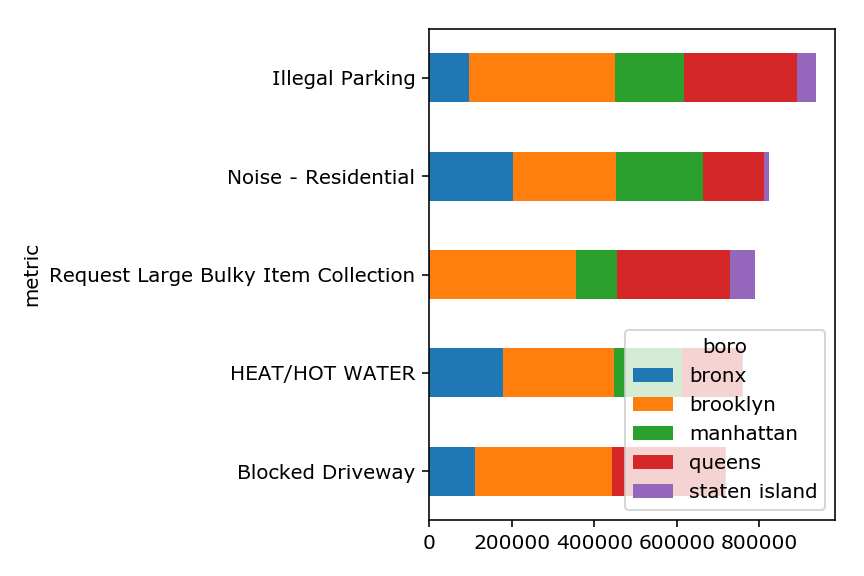
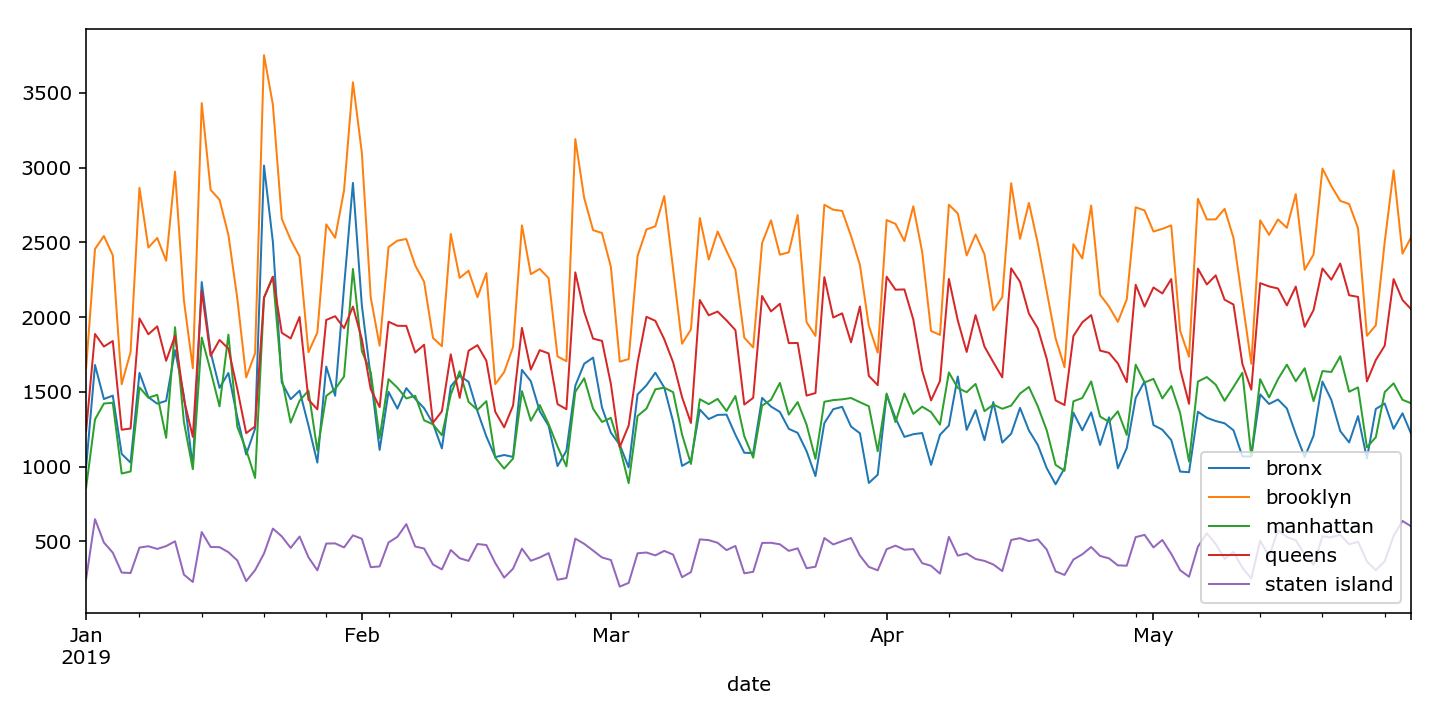

In [13]:
panel.servable()